In [2]:
# Konfiguracja startowa
import pickle

DO_TRAIN = False  # czy trenowanie ma być wykonane na nowo, czy wczytane z dysku (jak z dysku to też zbiór testowy jest z dysku, augmentacja itd.)

def load_cache(fn):
    with open(fn, 'rb') as cf:
        return pickle.load(cf)


def write_cache(fn, data):
    with open(fn, 'wb') as cf:
        pickle.dump(data, cf)

In [3]:
# Załadowanie hitów w PNG z katalogu hit-images-final2
# z podziałem na "dot", "track" i "worm" (podkatalogi)

from align_images_pca import align_image
from PIL import Image
import numpy as np
import glob


CACHE_IMAGES = 'cache/images_v2.pickle'

ALL_SRC = 'wybrane_final'


def load_image(image_path, align=True):
    img = Image.open(image_path)
    img = img.convert('L')
    image = np.asarray(img)
    #image = np.asarray(Image.open(image_path).convert('L'))
    if align:
        image = align_image(image)
    mask = np.where(image > 25, 1, 0)
    image = mask * image
    if np.max(image) == 0:
        return None
    image = image.astype(np.float32) / np.max(image)
    image = np.expand_dims(image, 2)
    return image


def load_images(src):
    images = []
    files_used = []
    files = list(glob.glob("%s/*.png" % src))
    files = sorted(files)
    for image_path in files:
        image = load_image(src)
        if image is None:
            continue
        images.append(image)
        files_used.append(image_path)
    return np.asarray(images), files_used


if DO_TRAIN:
    all_set, all_files = load_images(ALL_SRC)
    write_cache(CACHE_IMAGES, [all_set, all_files])
else:
    [all_set, all_files] = load_cache(CACHE_IMAGES)

print('len(all_set): %d' % all_set.shape[0])

len(all_set): 13824


In [4]:
# augmentacja przez mirror, czyli pomnożenie próbek 2x przez dodanie lustrzanie odbitych

import pickle
CACHE_AUGMENTATION = 'cache/augmentation_v2.pickle'

def augmentation_mirror(src, files):
    images = []
    files_aug = []
    for i in range(0, len(src)):
        img = src[i]
        images.append(img)
        images.append(np.flip(img))
        files_aug.append(files[i])
        files_aug.append(files[i])
    return np.asarray(images), files_aug

if DO_TRAIN:
    all2_set, all2_files = augmentation_mirror(all_set, all_files)
    write_cache(CACHE_AUGMENTATION, [all2_set, all2_files])
else:
    [all2_set, all2_files] = load_cache(CACHE_AUGMENTATION)

print('len(dots2_set): %d' % all2_set.shape[0])

len(dots2_set): 27648


In [5]:
# wygenerowanie zbioru train, validate i test o proporcjach odpowiednio 60%, 20% i 20%
# zwracane listy zawierają indeksy próbek, które zostały przydzielone do ww. ziorów

import pickle
CACHE_DIV = 'cache/sets_tvt.pickle'

def train_validate_test_split(df, train_percent=.8, seed=None):
    p = np.random.permutation(df.shape[0])
    n = int(train_percent * len(p))
    train = p[:n]
    validation = p[n:]
    return train, validation

if DO_TRAIN:
    all2_train, all2_validate = train_validate_test_split(all2_set)
    write_cache(CACHE_DIV, [all2_train, all2_validate])
else:
    [all2_train, all2_validate] = load_cache(CACHE_DIV)

print('len(all2_set): %d/%d' % (all2_train.shape[0], all2_validate.shape[0]))

len(all2_set): 22118/5530


In [6]:
# wytrenowanie kanałów
# * tracks
# * tnd (tracks and dots)

from commons import *
from dataset_loader import load_from_file
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

#DOTS_DST = 'cache/dots_100000.pickle'
#ARTIFACTS_DST = 'cache/artifacts_100000.pickle'

#DOTS_AC = 'cache/dots_100000.h5'
#TRACKS_AC = 'cache/th_dots_optics_100000.h5'
#WORMS_AC = 'cache/worms_100000.h5'
#ARTIFACTS_AC = 'cache/artifacts_100000.h5'
ALL_AC = 'cache/th_all_%d.h5'

def train_and_test(train_set, validation_set, fn_template, latentDim=16):
    fn = fn_template % latentDim
    autoencoder = original_autoencoder(latentDim=latentDim)
    autoencoder = train_or_cache(train_set, autoencoder, fn, validation_set=validation_set, force_train=True, latentDim=latentDim)

    for df_func, df_name in zip(
            [dm_func_mean],
            ['mean']
    ):
        for img_set, set_names in zip([validation_set], ['train']):
            decoded = autoencoder.predict(img_set)

            vis, errors = visualize_predictions(decoded, img_set, df_func, False, 16)
            img_path = fn.replace('.h5', '-vis.png')
            hist_path = fn.replace('.h5', '-hist.png')
            cv2.imwrite(img_path, vis)
            display(Image.open(img_path))
            if len(img_set) > 256:
                vis, errors = visualize_predictions(decoded, img_set, df_func, False)
                img_path = fn.replace('.h5', '-vis_full.png')
                cv2.imwrite(img_path, vis)

            plt.figure(figsize=(8,6))
            plt.hist(errors, bins=100, alpha=0.5, label=set_names)
            plt.xlabel("Data", size=14)
            plt.ylabel("Count", size=14)
            plt.title(df_name)
            plt.legend(loc='upper right')
            plt.savefig(hist_path)

if DO_TRAIN:
    for latentD in [16]:
        train_and_test(all2_set[all2_train], all2_set[all2_validate], ALL_AC, latentD)

In [7]:
if DO_TRAIN:
    for latentD in [2, 4, 6, 8, 12, 24, 32, 48, 64]:
        train_and_test(all2_set[all2_train], all2_set[all2_validate], ALL_AC, latentD)

In [8]:
# zapis embeddingu do pliku

from keras.models import load_model

def encoder_embedding(model_file, test_set):
    encoder = load_model(model_file.replace('.h5', '-encoder.h5'))
    embedding = encoder.predict(test_set)
    #with_c = np.vstack([v, np.ones(v.shape) * c])
    #transposed = with_c.transpose()
    return embedding

#all_embedding = encoder_embedding(ALL_AC % 64, all_set)
#all_embedding_files = np.hstack(all_files)


# np.save("res/emb_array_all_%d" % 16, all_embedding)

# with open("res/file_list_all.txt", 'w') as fp:
#     for ff in all_embedding_files:
#         fp.write(ff + "\n")


In [9]:
zero_to_one = (np.asarray(range(10)) + 1) / 10.0
one_to_ten = np.asarray(range(9)) + 2
ten_to_hundreds = (np.asarray(range(39)) + 2) * 10

eps_used = list((np.hstack([zero_to_one, one_to_ten, ten_to_hundreds])))
print(eps_used)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0]


In [10]:
def find_sigma(func, embedding, t_files, latentDim, min_samples=5, start_eps=200, percent=0.2):
    size = float(embedding.shape[0])
    left_eps = 0.1
    right_eps = 1000.0
    looking_count = round(size * (percent / 100.0))
    while True:
        eps = (left_eps + right_eps) / 2.0
        p = func(embedding, t_files, latentDim, eps, False, min_samples)
        if p == looking_count:
            break

        if p > looking_count:
            left_eps = eps
        else:
            right_eps = eps
    print('Znalezione: latentDim=%d, min_samples=%d, eps=%f' % (latentDim, min_samples, eps))
    func(embedding, t_files, latentDim, eps, True, min_samples)
    return eps


looking_ld = [2, 4, 6, 8, 12, 16, 24, 32, 48, 64]
looking_ms = [3, 4, 5, 6, 7, 8]

All files: 13824
wybrane_final\23116709.png
wybrane_final\17361478.png
wybrane_final\21049828.png
wybrane_final\14029635.png
wybrane_final\19686179.png
wybrane_final\13845184.png
wybrane_final\1357864.png
wybrane_final\9621040.png
wybrane_final\22005919.png
wybrane_final\11088069.png
wybrane_final\24626711.png
wybrane_final\7606495.png
wybrane_final\13843458.png
wybrane_final\11634237.png
wybrane_final\21974874.png
wybrane_final\18231255.png
wybrane_final\12008545.png
wybrane_final\1365429.png
wybrane_final\23149347.png
wybrane_final\7075694.png
wybrane_final\14220572.png
wybrane_final\11809278.png
wybrane_final\1369370.png
wybrane_final\18287015.png
wybrane_final\23131541.png
wybrane_final\1322025.png
wybrane_final\24598218.png
wybrane_final\24282205.png


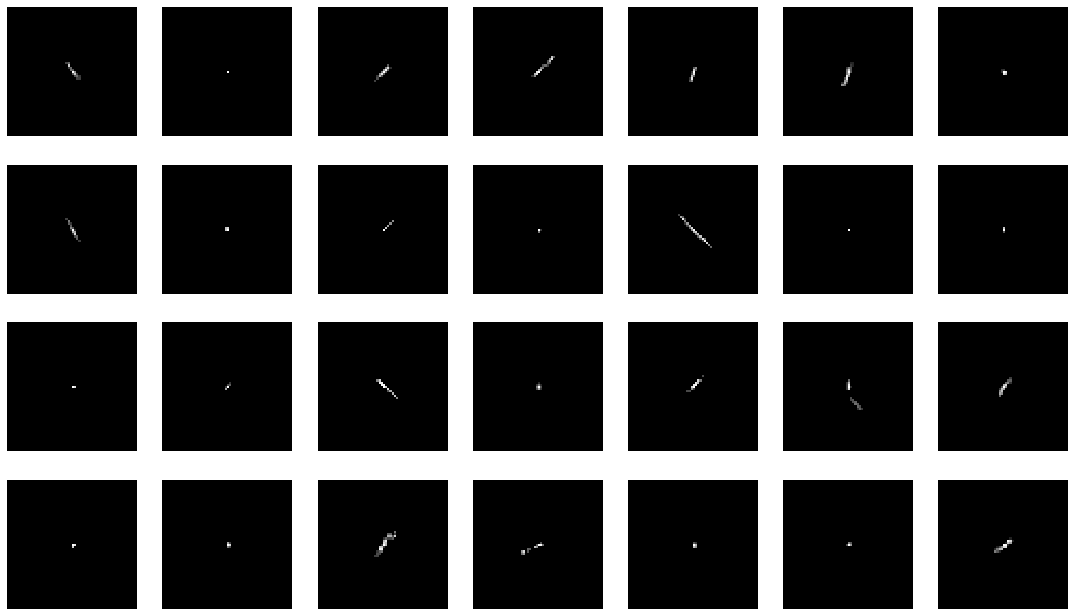

All files: 13824
wybrane_final\11623626.png
wybrane_final\16001286.png
wybrane_final\20445720.png
wybrane_final\19700089.png
wybrane_final\24168412.png
wybrane_final\23051370.png
wybrane_final\23844431.png
wybrane_final\22323598.png
wybrane_final\11896443.png
wybrane_final\15482083.png
wybrane_final\15489657.png
wybrane_final\1354377.png
wybrane_final\15647096.png
wybrane_final\15018164.png
wybrane_final\1832287.png
wybrane_final\24594562.png
wybrane_final\24630597.png
wybrane_final\9800108.png
wybrane_final\24604786.png
wybrane_final\1767166.png
wybrane_final\7200454.png
wybrane_final\21978937.png
wybrane_final\24590090.png
wybrane_final\24591615.png
wybrane_final\1357969.png
wybrane_final\24240029.png
wybrane_final\11895928.png
wybrane_final\24287706.png


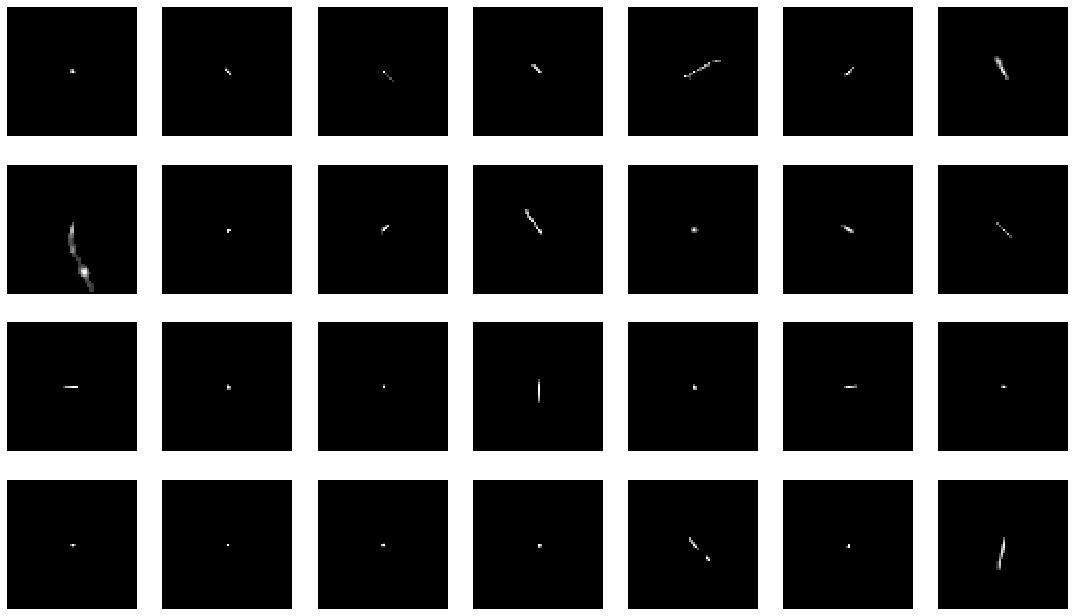

All files: 13824
wybrane_final\13696014.png
wybrane_final\22365160.png
wybrane_final\1358435.png
wybrane_final\18430650.png
wybrane_final\21864717.png
wybrane_final\24604012.png
wybrane_final\11800788.png
wybrane_final\1321341.png
wybrane_final\17579156.png
wybrane_final\21971407.png
wybrane_final\24597742.png
wybrane_final\11698723.png
wybrane_final\11897194.png
wybrane_final\24590799.png
wybrane_final\24622656.png
wybrane_final\17359503.png
wybrane_final\10260979.png
wybrane_final\16074468.png
wybrane_final\22219592.png
wybrane_final\22499942.png
wybrane_final\1368407.png
wybrane_final\10075751.png
wybrane_final\11800138.png
wybrane_final\22265284.png
wybrane_final\24621829.png
wybrane_final\1350222.png
wybrane_final\22428844.png
wybrane_final\15426000.png


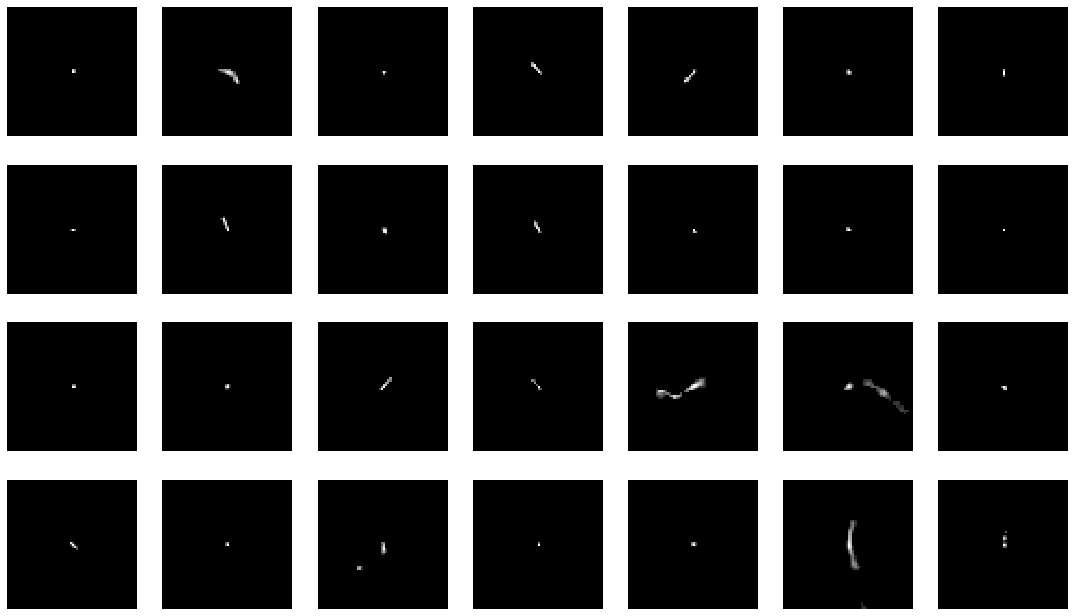

All files: 13824
wybrane_final\23945004.png
wybrane_final\11897732.png
wybrane_final\11848839.png
wybrane_final\1329715.png
wybrane_final\21969368.png
wybrane_final\20235640.png
wybrane_final\11442719.png
wybrane_final\14406417.png
wybrane_final\7057557.png
wybrane_final\24604255.png
wybrane_final\11808709.png
wybrane_final\1865212.png
wybrane_final\22280674.png
wybrane_final\22051220.png
wybrane_final\13605732.png
wybrane_final\22667844.png
wybrane_final\23778234.png
wybrane_final\19413831.png
wybrane_final\1326246.png
wybrane_final\24287651.png
wybrane_final\13697380.png
wybrane_final\24604255.png
wybrane_final\11809447.png
wybrane_final\18641264.png
wybrane_final\1745147.png
wybrane_final\7060202.png
wybrane_final\11898629.png
wybrane_final\23214854.png


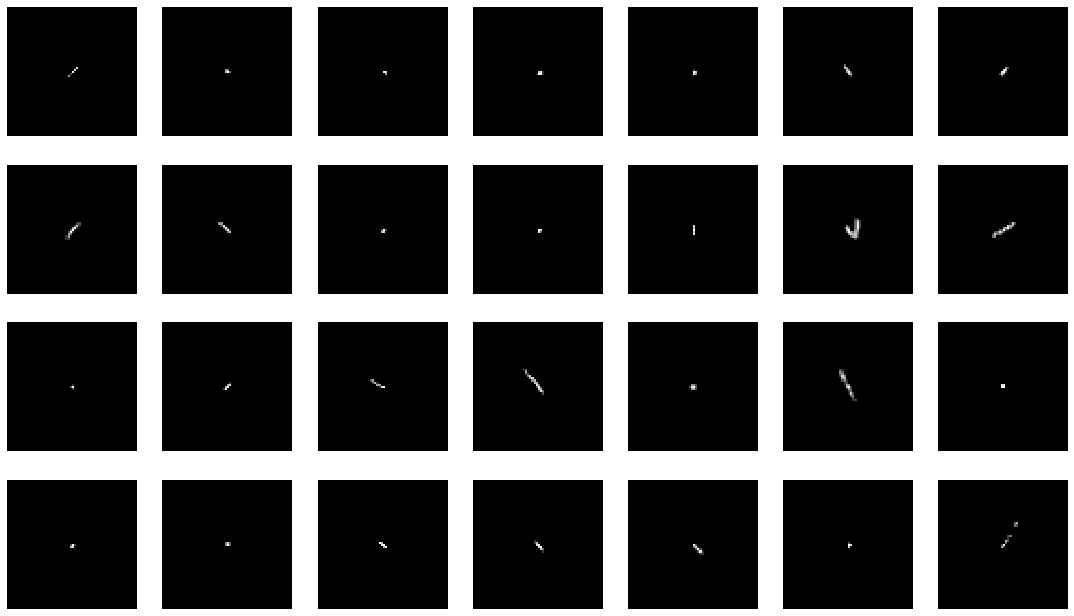

All files: 13824
wybrane_final\21971998.png
wybrane_final\22232134.png
wybrane_final\1366559.png
wybrane_final\23104615.png
wybrane_final\1350291.png
wybrane_final\18040947.png
wybrane_final\24595571.png
wybrane_final\21978614.png
wybrane_final\17676822.png
wybrane_final\17851118.png
wybrane_final\24598374.png
wybrane_final\22351432.png
wybrane_final\18802708.png
wybrane_final\21973638.png
wybrane_final\17362337.png
wybrane_final\24630222.png
wybrane_final\13687783.png
wybrane_final\22113319.png
wybrane_final\23446405.png
wybrane_final\17034106.png
wybrane_final\23742633.png
wybrane_final\1326089.png
wybrane_final\24593543.png
wybrane_final\23126443.png
wybrane_final\22395180.png
wybrane_final\1302999.png
wybrane_final\13893189.png
wybrane_final\21971510.png


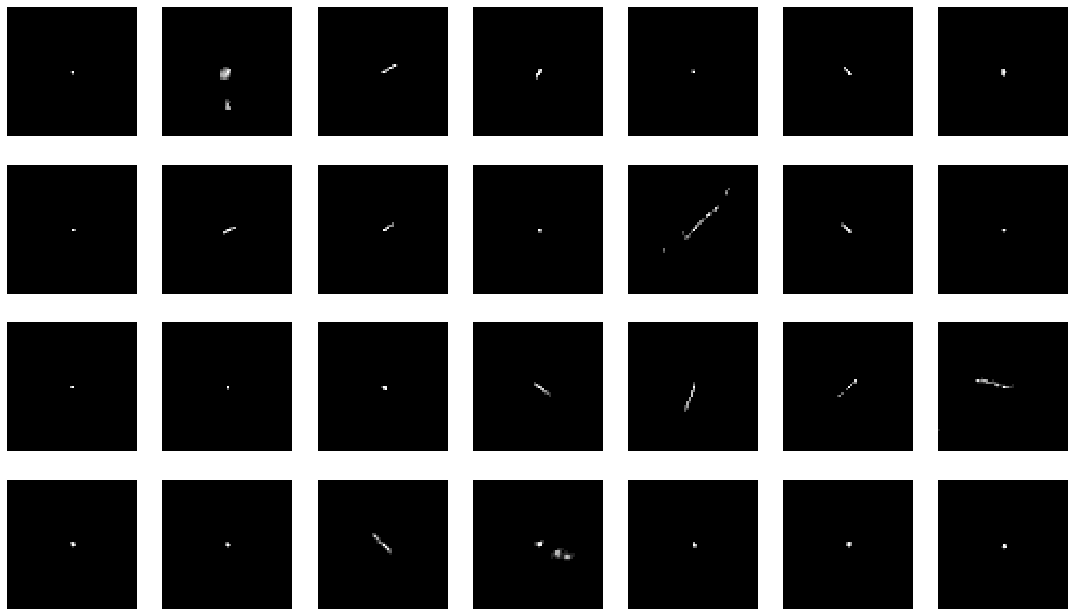

All files: 13824
wybrane_final\23117326.png
wybrane_final\24094968.png
wybrane_final\17858516.png
wybrane_final\15632782.png
wybrane_final\19686200.png
wybrane_final\1867762.png
wybrane_final\24591907.png
wybrane_final\22489399.png
wybrane_final\24624025.png
wybrane_final\23777943.png
wybrane_final\11812917.png
wybrane_final\5266337.png
wybrane_final\13602942.png
wybrane_final\11893970.png
wybrane_final\11865518.png
wybrane_final\21974808.png
wybrane_final\11897326.png
wybrane_final\21977665.png
wybrane_final\10260979.png
wybrane_final\11634534.png
wybrane_final\7418909.png
wybrane_final\22013091.png
wybrane_final\1358396.png
wybrane_final\23522020.png
wybrane_final\21051869.png
wybrane_final\11861195.png
wybrane_final\13844409.png
wybrane_final\1315779.png


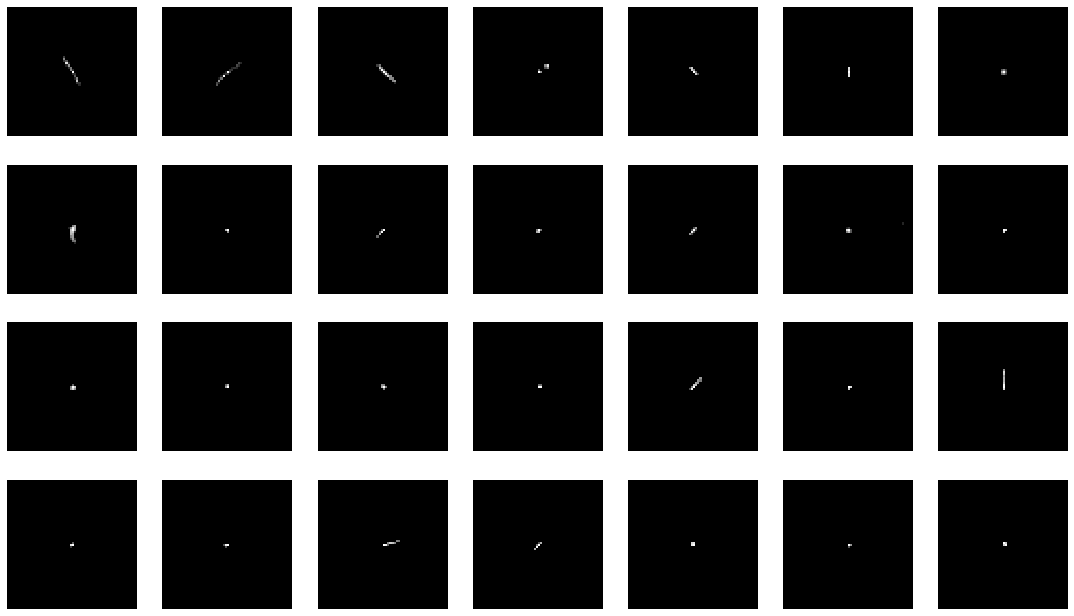

All files: 13824
wybrane_final\2698649.png
wybrane_final\22007366.png
wybrane_final\9859560.png
wybrane_final\17358551.png
wybrane_final\20267060.png
wybrane_final\1852499.png
wybrane_final\22111024.png
wybrane_final\24601881.png
wybrane_final\1302525.png
wybrane_final\11699323.png
wybrane_final\1373566.png
wybrane_final\13842585.png
wybrane_final\22265289.png
wybrane_final\11800874.png
wybrane_final\11822364.png
wybrane_final\23051271.png
wybrane_final\12845481.png
wybrane_final\22349363.png
wybrane_final\17230766.png
wybrane_final\22031457.png
wybrane_final\24438473.png
wybrane_final\24591125.png
wybrane_final\23378824.png
wybrane_final\21976359.png
wybrane_final\24592739.png
wybrane_final\23193873.png
wybrane_final\24598196.png
wybrane_final\11684269.png


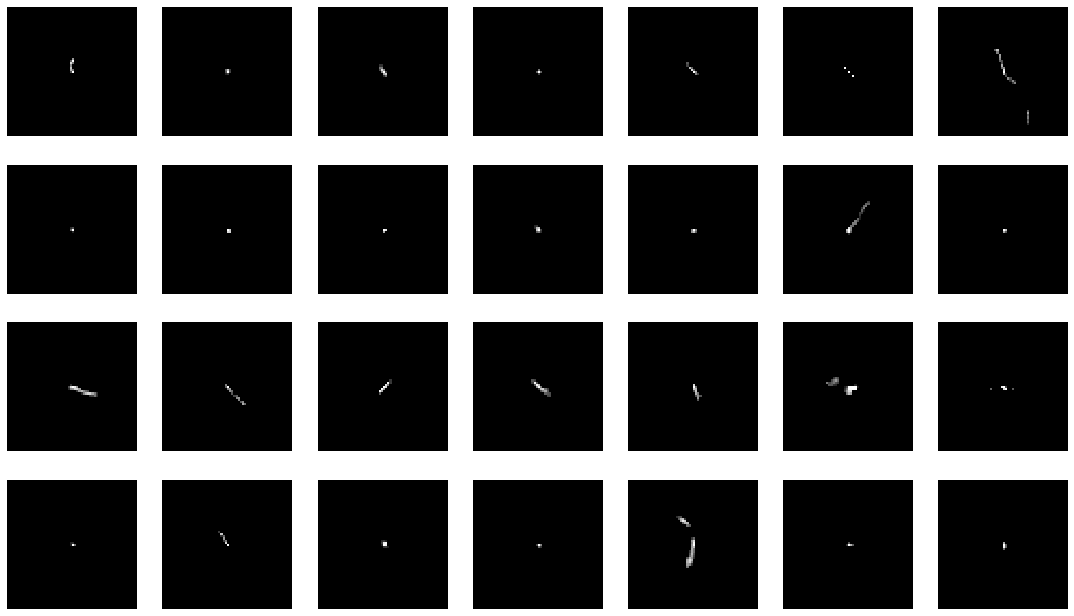

All files: 13824
wybrane_final\12252296.png
wybrane_final\13838629.png
wybrane_final\17040073.png
wybrane_final\21983504.png
wybrane_final\11811789.png
wybrane_final\21979312.png
wybrane_final\18444908.png
wybrane_final\17003448.png
wybrane_final\1316969.png
wybrane_final\21972565.png
wybrane_final\11863523.png
wybrane_final\22174675.png
wybrane_final\15647096.png
wybrane_final\5831475.png
wybrane_final\9012121.png
wybrane_final\16061774.png
wybrane_final\13842934.png
wybrane_final\17679012.png
wybrane_final\10622318.png
wybrane_final\24590605.png
wybrane_final\11604217.png
wybrane_final\22209629.png
wybrane_final\11898697.png
wybrane_final\24591034.png
wybrane_final\1303298.png
wybrane_final\11602311.png
wybrane_final\23524530.png
wybrane_final\11813501.png


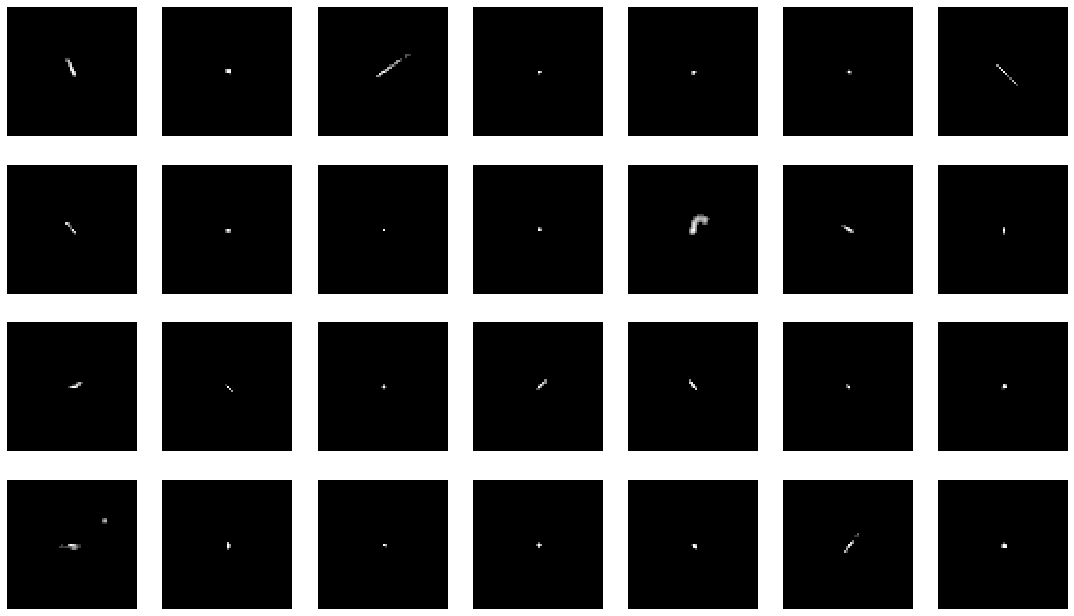

All files: 13824
wybrane_final\13610076.png
wybrane_final\7622993.png
wybrane_final\17338190.png
wybrane_final\13602129.png
wybrane_final\9464665.png
wybrane_final\1390835.png
wybrane_final\24186088.png
wybrane_final\15032830.png
wybrane_final\24594040.png
wybrane_final\3264246.png
wybrane_final\11809237.png
wybrane_final\15670648.png
wybrane_final\13697058.png
wybrane_final\6452529.png
wybrane_final\24590279.png
wybrane_final\13259147.png
wybrane_final\16096684.png
wybrane_final\1499603.png
wybrane_final\16622869.png
wybrane_final\13832169.png
wybrane_final\16234804.png
wybrane_final\1345234.png
wybrane_final\12428992.png
wybrane_final\23116385.png
wybrane_final\13693756.png
wybrane_final\11897172.png
wybrane_final\10053386.png
wybrane_final\1373566.png


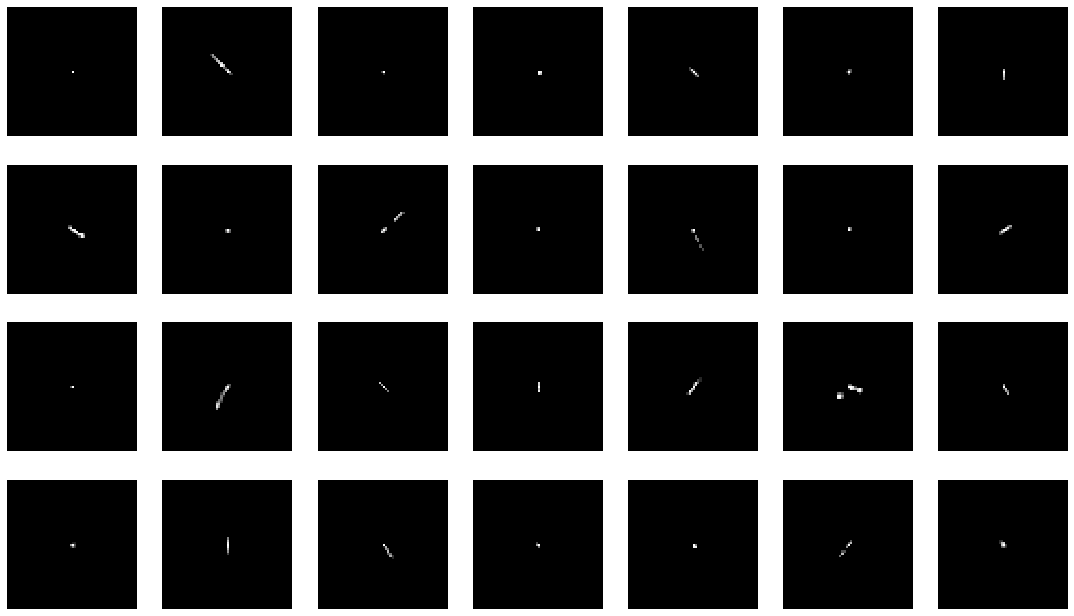

All files: 13824
wybrane_final\11862597.png
wybrane_final\23635356.png
wybrane_final\24594541.png
wybrane_final\7334381.png
wybrane_final\16428373.png
wybrane_final\13658701.png
wybrane_final\11819002.png
wybrane_final\1368877.png
wybrane_final\24437391.png
wybrane_final\24603186.png
wybrane_final\1314464.png
wybrane_final\11681560.png
wybrane_final\9054663.png
wybrane_final\4226973.png
wybrane_final\11684269.png
wybrane_final\5246494.png
wybrane_final\23424513.png
wybrane_final\11683448.png
wybrane_final\24655105.png
wybrane_final\22033316.png
wybrane_final\21973047.png
wybrane_final\1310895.png
wybrane_final\23472817.png
wybrane_final\21978052.png
wybrane_final\17885329.png
wybrane_final\24431000.png
wybrane_final\19498137.png
wybrane_final\16753801.png


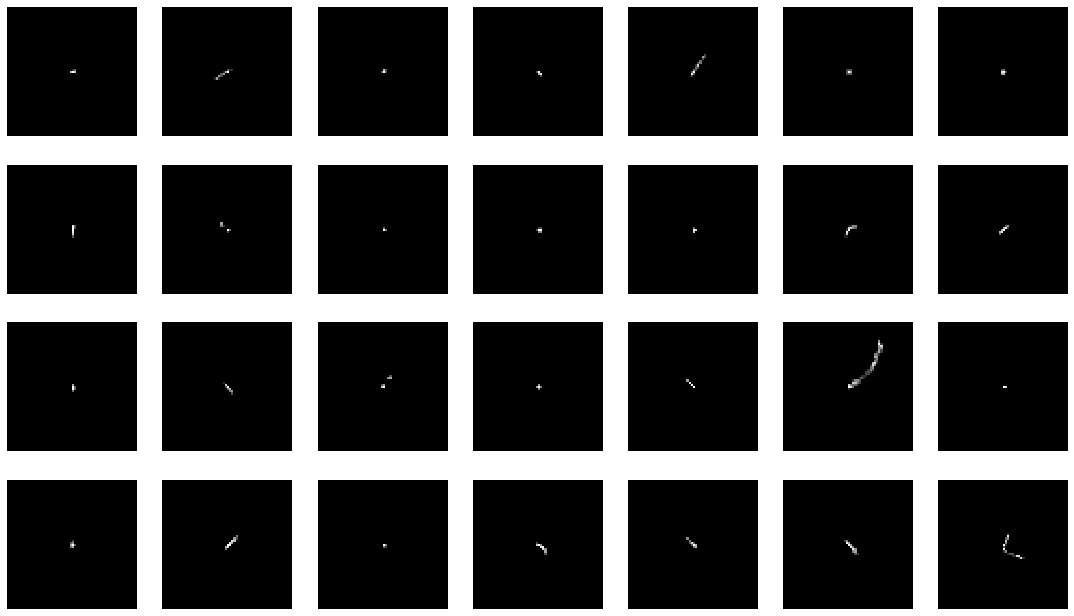

All files: 13824
wybrane_final\1375630.png
wybrane_final\18012596.png
wybrane_final\13814030.png
wybrane_final\1310381.png
wybrane_final\11898590.png
wybrane_final\19820955.png
wybrane_final\22322862.png
wybrane_final\9888939.png
wybrane_final\24597902.png
wybrane_final\24627846.png
wybrane_final\22305611.png
wybrane_final\1368581.png
wybrane_final\24630332.png
wybrane_final\16034973.png
wybrane_final\23058875.png
wybrane_final\1351157.png
wybrane_final\21972565.png
wybrane_final\17062563.png
wybrane_final\13843943.png
wybrane_final\21974743.png
wybrane_final\22300605.png
wybrane_final\24602254.png
wybrane_final\24602020.png
wybrane_final\21977749.png
wybrane_final\16073561.png
wybrane_final\11898769.png
wybrane_final\13610184.png
wybrane_final\21983798.png


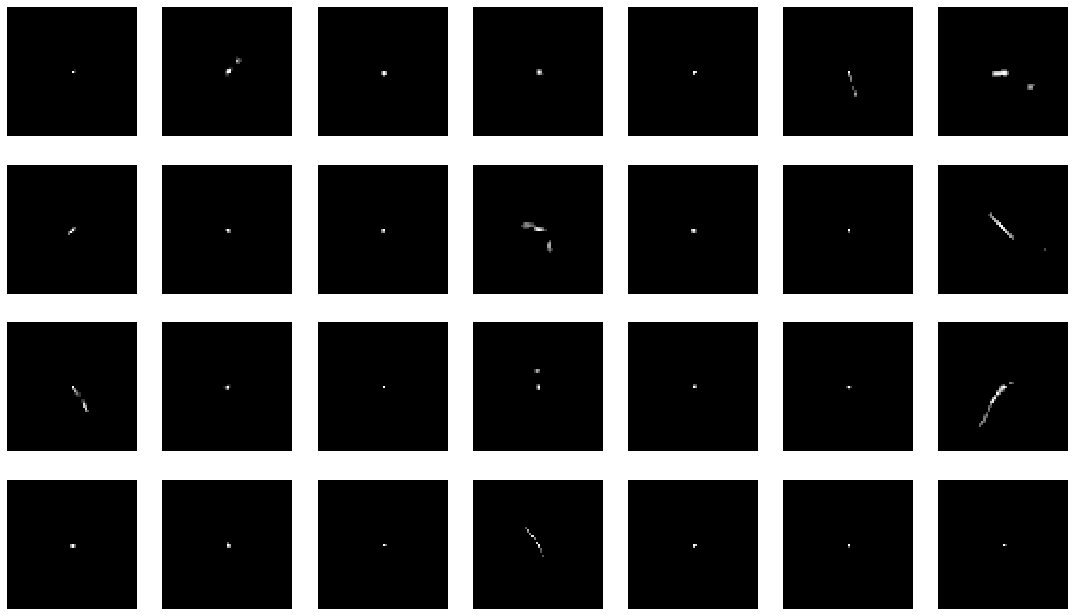

All files: 13824
wybrane_final\17019991.png
wybrane_final\1350682.png
wybrane_final\12008685.png
wybrane_final\22448493.png
wybrane_final\13825047.png
wybrane_final\11650372.png
wybrane_final\1317214.png
wybrane_final\23841904.png
wybrane_final\1300925.png
wybrane_final\13804972.png
wybrane_final\11864576.png
wybrane_final\22354720.png
wybrane_final\23599146.png
wybrane_final\22704493.png
wybrane_final\11800417.png
wybrane_final\18253571.png
wybrane_final\24270694.png
wybrane_final\11898423.png
wybrane_final\16298802.png
wybrane_final\18861036.png
wybrane_final\23057771.png
wybrane_final\24614015.png
wybrane_final\11838954.png
wybrane_final\24326837.png
wybrane_final\13619407.png
wybrane_final\1382963.png
wybrane_final\2805175.png
wybrane_final\21978583.png


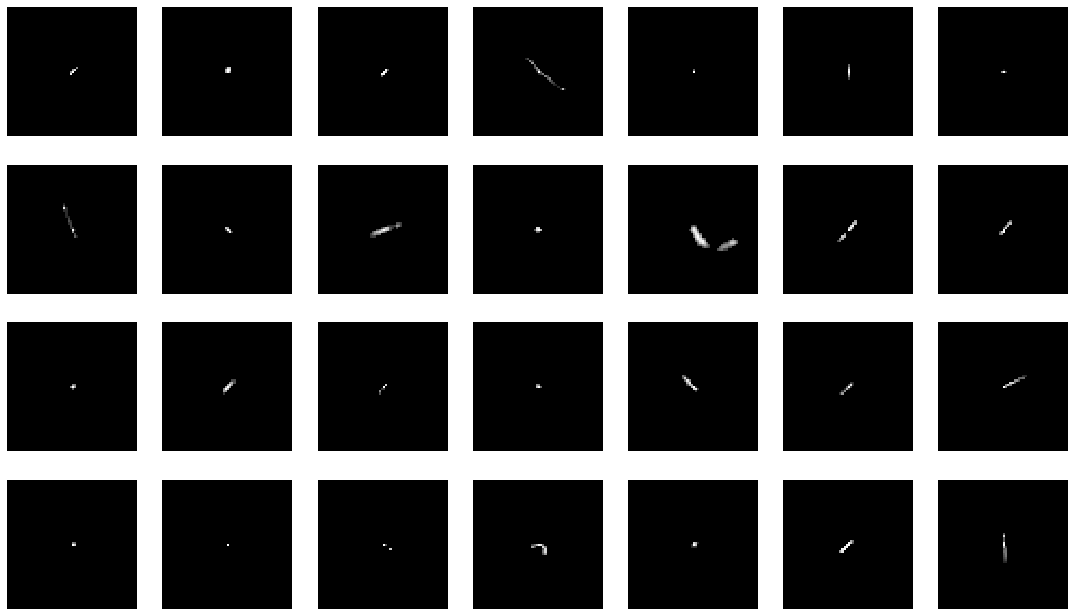

All files: 13824
wybrane_final\24603883.png
wybrane_final\22054680.png
wybrane_final\11681467.png
wybrane_final\11821548.png
wybrane_final\1851780.png
wybrane_final\22236788.png
wybrane_final\11858576.png
wybrane_final\4492253.png
wybrane_final\23051370.png
wybrane_final\24274103.png
wybrane_final\11698858.png
wybrane_final\22497929.png
wybrane_final\24591947.png
wybrane_final\22357430.png
wybrane_final\22437067.png
wybrane_final\11822364.png
wybrane_final\1365008.png
wybrane_final\24139535.png
wybrane_final\1315865.png
wybrane_final\11823281.png
wybrane_final\11810215.png
wybrane_final\11898101.png
wybrane_final\1867516.png
wybrane_final\24594073.png
wybrane_final\1383078.png
wybrane_final\6206187.png
wybrane_final\1370374.png
wybrane_final\10260979.png


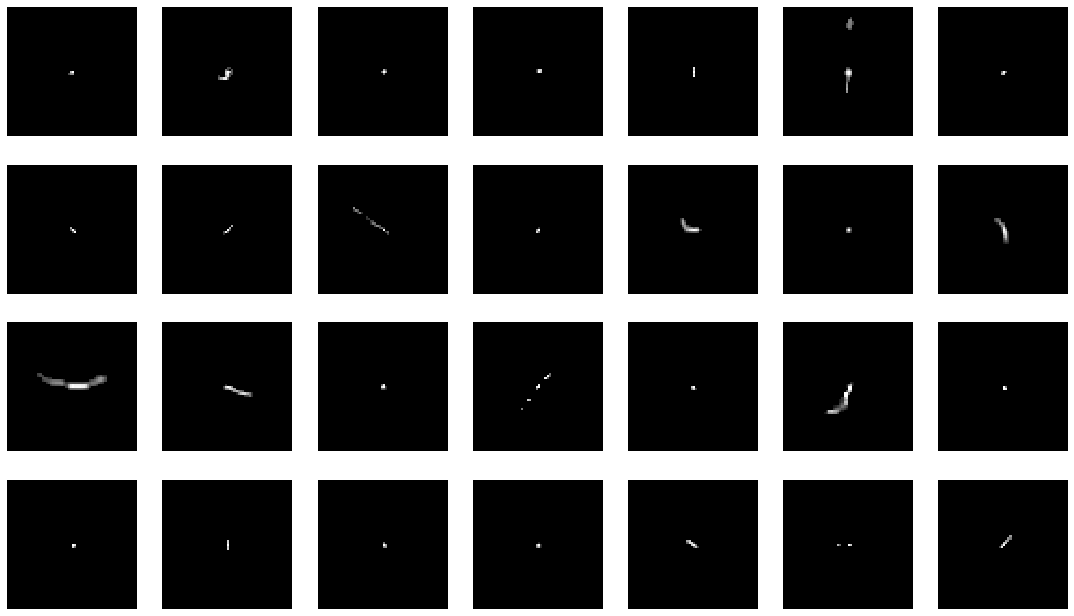

All files: 13824
wybrane_final\1669982.png
wybrane_final\23111209.png
wybrane_final\21974313.png
wybrane_final\16259039.png
wybrane_final\5273514.png
wybrane_final\22436675.png
wybrane_final\24603107.png
wybrane_final\21983253.png
wybrane_final\24308358.png
wybrane_final\21068319.png
wybrane_final\21981798.png
wybrane_final\9076376.png
wybrane_final\24602952.png
wybrane_final\21978707.png
wybrane_final\1351273.png
wybrane_final\11069965.png
wybrane_final\11812026.png
wybrane_final\1350554.png
wybrane_final\16034700.png
wybrane_final\22038875.png
wybrane_final\24597746.png
wybrane_final\23431996.png
wybrane_final\24628408.png
wybrane_final\21983459.png
wybrane_final\18610938.png
wybrane_final\11625484.png
wybrane_final\24594326.png
wybrane_final\11681078.png


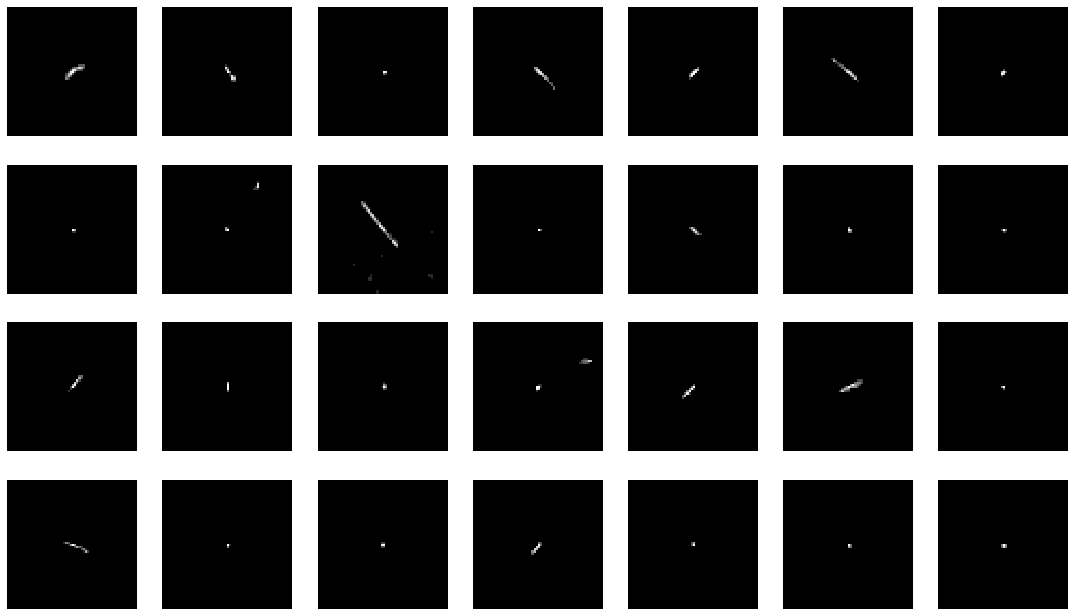

All files: 13824
wybrane_final\11680783.png
wybrane_final\23422612.png
wybrane_final\21983202.png
wybrane_final\11896794.png
wybrane_final\13836743.png
wybrane_final\6610507.png
wybrane_final\22499941.png
wybrane_final\11698727.png
wybrane_final\24318698.png
wybrane_final\17362887.png
wybrane_final\22667952.png
wybrane_final\11811658.png
wybrane_final\11896840.png
wybrane_final\1402371.png
wybrane_final\24594593.png
wybrane_final\24597690.png
wybrane_final\21983561.png
wybrane_final\10603968.png
wybrane_final\1357380.png
wybrane_final\23058922.png
wybrane_final\1853299.png
wybrane_final\24603141.png
wybrane_final\10428598.png
wybrane_final\24593276.png
wybrane_final\11896255.png
wybrane_final\11899082.png
wybrane_final\24594312.png
wybrane_final\1365008.png


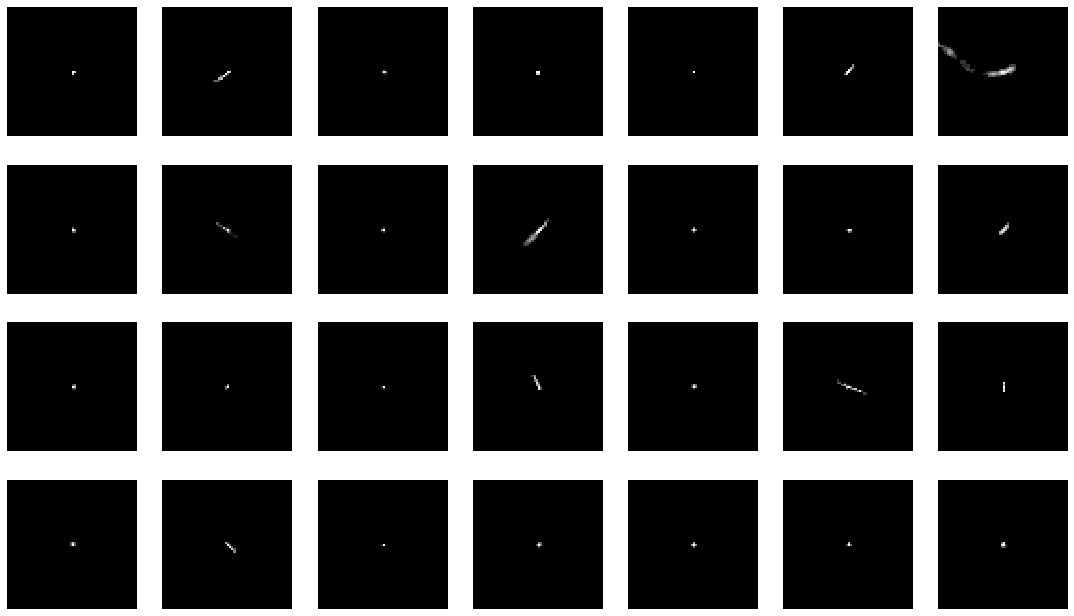

All files: 13824
wybrane_final\1369187.png
wybrane_final\1368850.png
wybrane_final\24178184.png
wybrane_final\11837984.png
wybrane_final\11896694.png
wybrane_final\9247097.png
wybrane_final\24627203.png
wybrane_final\24598283.png
wybrane_final\1366352.png
wybrane_final\16428710.png
wybrane_final\21979260.png
wybrane_final\22034306.png
wybrane_final\1309232.png
wybrane_final\13829425.png
wybrane_final\16862341.png
wybrane_final\23314715.png
wybrane_final\17361073.png
wybrane_final\19287528.png
wybrane_final\21974678.png
wybrane_final\18698545.png
wybrane_final\22449068.png
wybrane_final\13842346.png
wybrane_final\11809447.png
wybrane_final\24622840.png
wybrane_final\15424356.png
wybrane_final\17000160.png
wybrane_final\21978052.png
wybrane_final\24323833.png


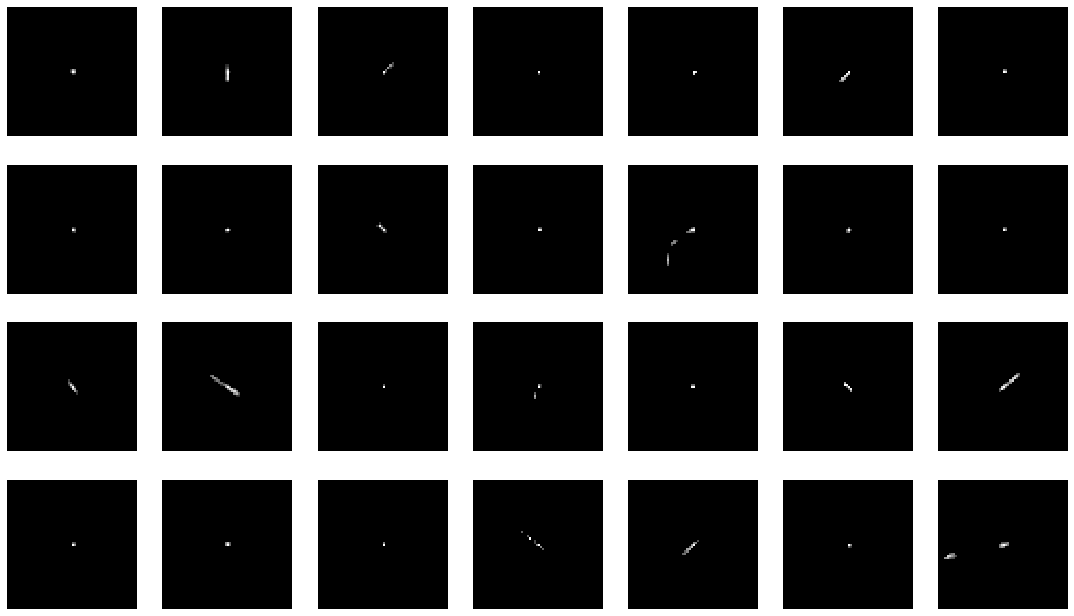

All files: 13824
wybrane_final\13836146.png
wybrane_final\24630323.png
wybrane_final\21509734.png
wybrane_final\24135587.png
wybrane_final\8401397.png
wybrane_final\24622925.png
wybrane_final\18263373.png
wybrane_final\1353895.png
wybrane_final\11840272.png
wybrane_final\16292497.png
wybrane_final\24602569.png
wybrane_final\24591577.png
wybrane_final\19277073.png
wybrane_final\24574034.png
wybrane_final\19633148.png
wybrane_final\24305759.png
wybrane_final\5474106.png
wybrane_final\11832689.png
wybrane_final\11864136.png
wybrane_final\15668178.png
wybrane_final\11837926.png
wybrane_final\4875297.png
wybrane_final\13837684.png
wybrane_final\11683313.png
wybrane_final\13842743.png
wybrane_final\6228829.png
wybrane_final\8267516.png
wybrane_final\1312620.png


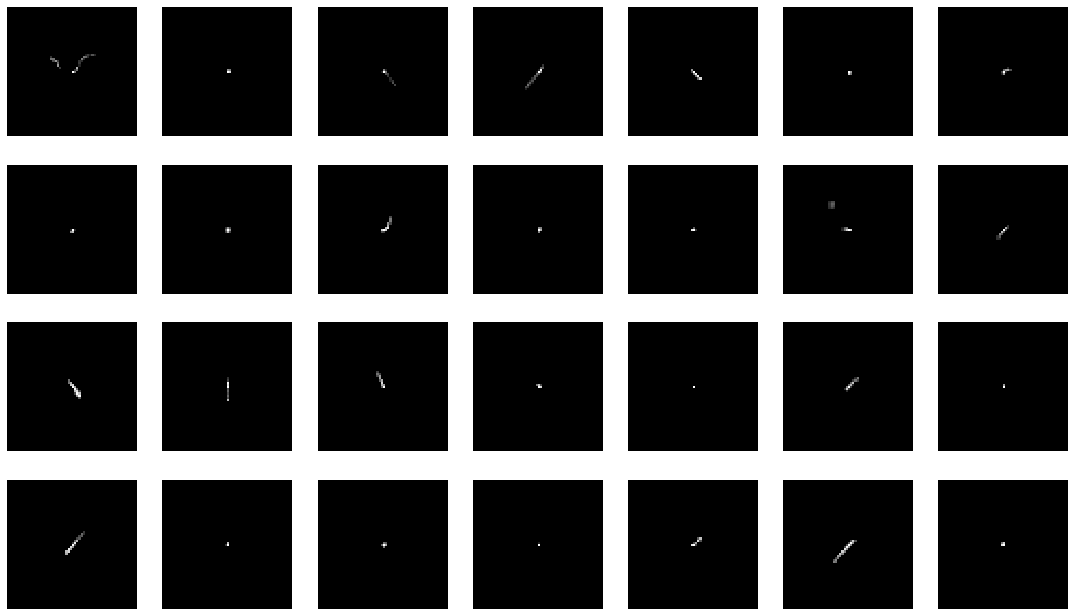

All files: 13824
wybrane_final\24594822.png
wybrane_final\5909930.png
wybrane_final\24594713.png
wybrane_final\13816712.png
wybrane_final\1308993.png
wybrane_final\6859585.png
wybrane_final\5034058.png
wybrane_final\1365756.png
wybrane_final\22456020.png
wybrane_final\21972665.png
wybrane_final\21245180.png
wybrane_final\11896800.png
wybrane_final\24601187.png
wybrane_final\21974570.png
wybrane_final\24289541.png
wybrane_final\11900035.png
wybrane_final\18270323.png
wybrane_final\15426287.png
wybrane_final\1737396.png
wybrane_final\23769557.png
wybrane_final\1384123.png
wybrane_final\22027241.png
wybrane_final\21567287.png
wybrane_final\18271782.png
wybrane_final\22034706.png
wybrane_final\22391119.png
wybrane_final\22439098.png
wybrane_final\24591934.png


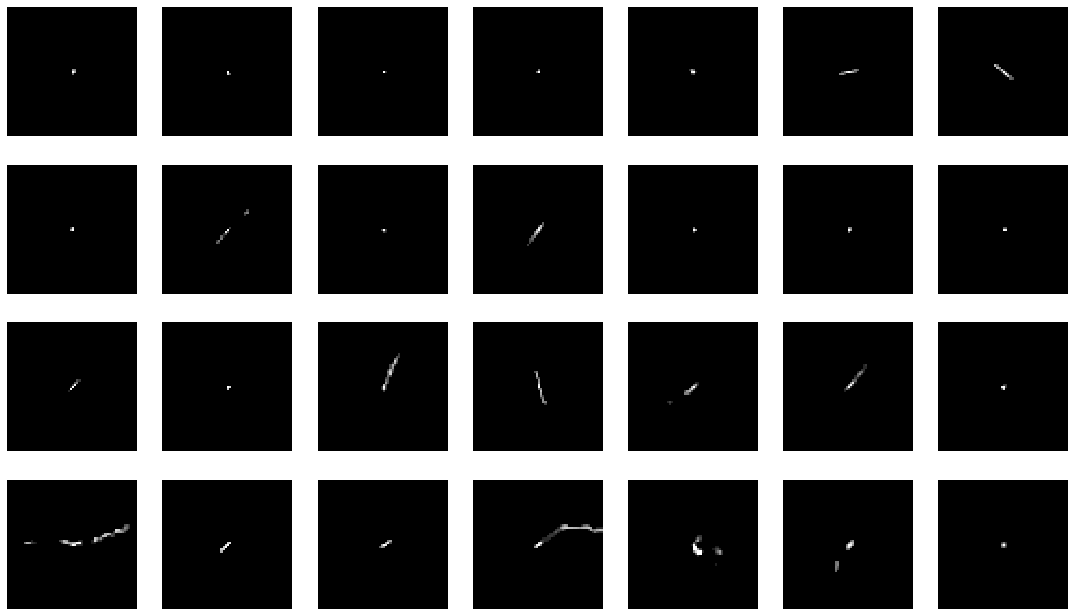

All files: 13824
wybrane_final\22365698.png
wybrane_final\18235557.png
wybrane_final\24602631.png
wybrane_final\11811387.png
wybrane_final\1358011.png
wybrane_final\18074449.png
wybrane_final\11679513.png
wybrane_final\24593232.png
wybrane_final\5041156.png
wybrane_final\13806409.png
wybrane_final\21919130.png
wybrane_final\1613894.png
wybrane_final\2617393.png
wybrane_final\24308542.png
wybrane_final\21975179.png
wybrane_final\23148347.png
wybrane_final\21246314.png
wybrane_final\24613915.png
wybrane_final\7240867.png
wybrane_final\22680991.png
wybrane_final\11834006.png
wybrane_final\11809917.png
wybrane_final\18265038.png
wybrane_final\11809962.png
wybrane_final\23507857.png
wybrane_final\11679276.png
wybrane_final\24593205.png
wybrane_final\11872097.png


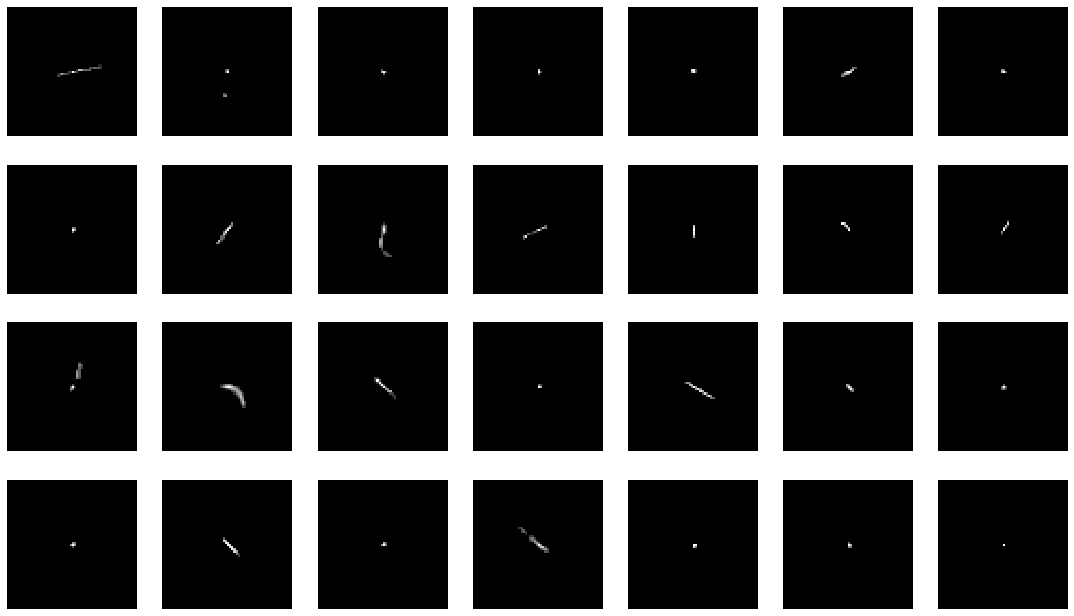

All files: 13824
wybrane_final\22675676.png
wybrane_final\24186088.png
wybrane_final\2447406.png
wybrane_final\11665972.png
wybrane_final\11898742.png
wybrane_final\22640990.png
wybrane_final\13842431.png
wybrane_final\13637136.png
wybrane_final\11899012.png
wybrane_final\24601938.png
wybrane_final\23654728.png
wybrane_final\4494546.png
wybrane_final\24613851.png
wybrane_final\16626396.png
wybrane_final\23941429.png
wybrane_final\11636025.png
wybrane_final\16647933.png
wybrane_final\22251551.png
wybrane_final\11895951.png
wybrane_final\24594580.png
wybrane_final\1322761.png
wybrane_final\13289924.png
wybrane_final\23654543.png
wybrane_final\24209079.png
wybrane_final\23518034.png
wybrane_final\24438473.png
wybrane_final\3061461.png
wybrane_final\11895794.png


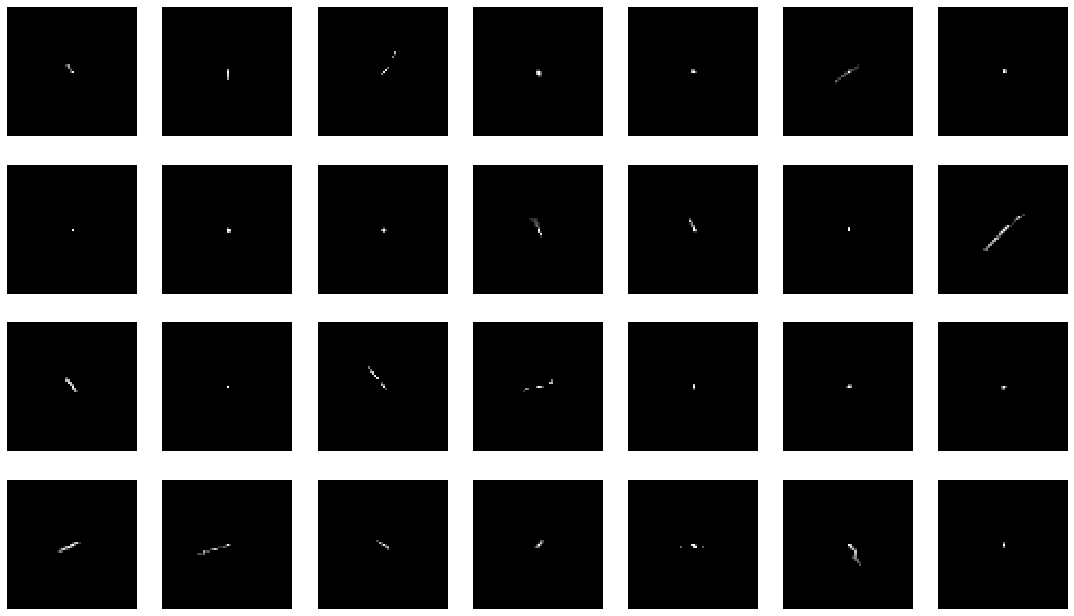

In [32]:
from random import randrange
import matplotlib.pyplot as plt

for i in range(20):
    fig = plt.figure(figsize=(19, 14))
    columns = 7
    rows = int(28 / 7) + 1

    print('All files: %d' % len(all_files))

    for aaa in range(28):
        index = randrange(len(all_files))
        img_help = load_image(all_files[index], False)
        print(all_files[index])

        aaa1 = aaa + 1
        r = fig.add_subplot(rows, columns, aaa1)
        r.axis("off")
        plt.imshow(img_help, cmap='gray', vmin=0, vmax=1, interpolation='none')
        plt.savefig('paper/random_%d.svg' % i)

    plt.show()